# Example of how to find peaks in a synthetic image
 - Create a set of 2D Gaussians
 - Find the center of the Guassian to integer accuracy
 - Optimize the position using Gaussian fitting for each peak

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# Import these from ncempy.algo
from ncempy.algo import gaussND
from ncempy.algo import peakFind

# Create a sample 2D Image
 - Gaussians are placed on a grid with some random small offsets
 - the variable coords are the known positions 
  - these will not be known in a real experiment

Coords shape = (25, 2)


<IPython.core.display.Javascript object>


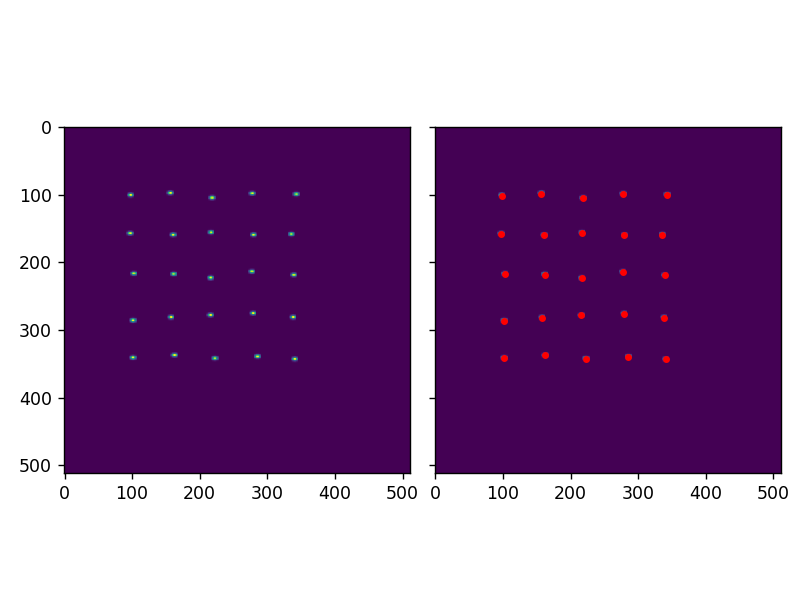

In [3]:
# Create coordinates with a random offset
coords = peakFind.lattice2D_2((1, 0), (0, 1), 2, 2, (0, 0), (5, 5))
rands = np.random.randn(coords.shape[0], coords.shape[1]) / 10
coords += rands
coords = np.array(coords)*30 + (100, 100)
print('Coords shape = {}'.format(coords.shape))

# Create an image with the coordinates as gaussians
kernel_shape = (11, 11)
simIm = peakFind.peaksToImage(coords, (512, 512), (1.75, 2.75), kernel_shape)
    
fg, ax = plt.subplots(1, 2, sharex=True,sharey=True)
ax[0].imshow(simIm)
ax[1].imshow(simIm)
ax[1].scatter(coords[:,1], coords[:,0],c='r',marker='.')
fg.tight_layout()

# Find the center pixel of each peak
 - uses ncempy.algo.peakFind.peakFind2D()
 - These will be integer values of the max peak positions.
 - Gaussian fitting will be used to find the smal random offsets
 - See end of notebook for an explanation as to how this works.

<IPython.core.display.Javascript object>


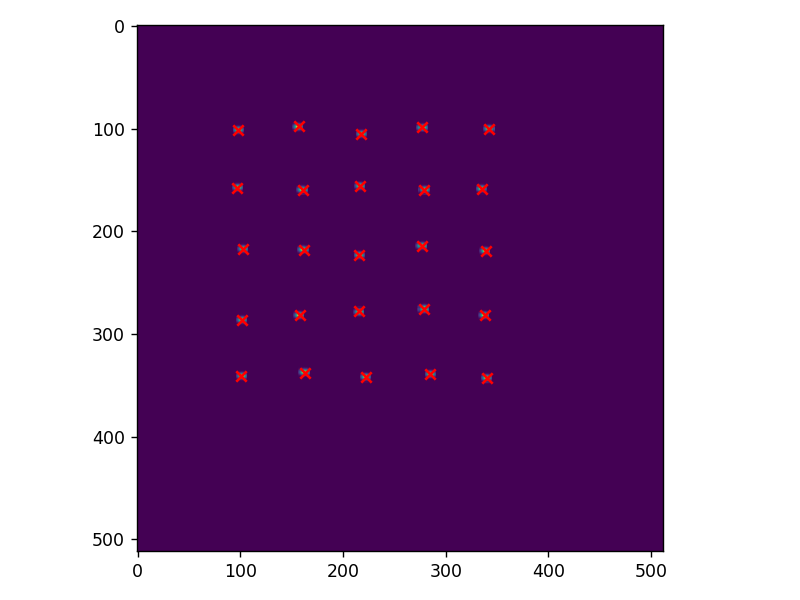

In [4]:
coords_found = peakFind.peakFind2D(simIm, 0.5)

fg, ax = plt.subplots(1,1)
ax.imshow(simIm)
_ = ax.scatter(coords_found[:,1],coords_found[:,0],c='r',marker='x')

# Use Gaussian fitting for sub-pixel fitting
 - Each peak is fit to a 2D Gaussian function
 - The average of the sigma values is printed

<IPython.core.display.Javascript object>


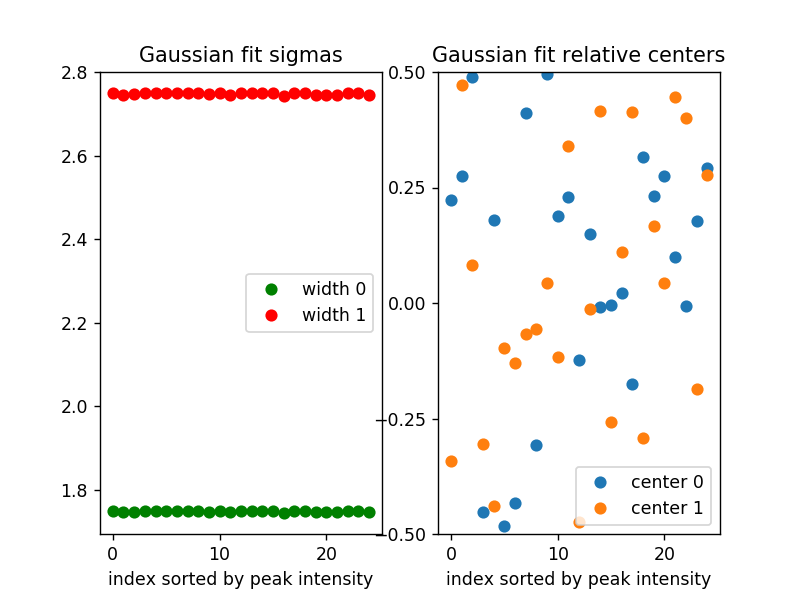

Sigma means [s_0, s_1]: [1.74888099 2.74839473]


In [6]:
optPeaks, optI, fittingValues = peakFind.fit_peaks_gauss2d(simIm, coords_found, 5, 
                                                           (1.5, 2.5), ((-1.5, -1.5,0,0),(1.5,1.5,3,3)))

# Plot the gaussian widths
f2, ax2 = plt.subplots(1, 2)
ax2[0].plot(optPeaks[:, 2],'go')
ax2[0].plot(optPeaks[:, 3],'ro')
ax2[0].set(title='Gaussian fit sigmas',xlabel='index sorted by peak intensity')
ax2[0].legend(labels=['width 0', 'width 1'])
stdMeans = np.mean(optPeaks[:, 2:4], axis=0)

# Print out the average of the fitted sigmas
print('Sigma means [s_0, s_1]: {}'.format(stdMeans))

# Plot the fitted center (relative from the intensity peak)
ax2[1].plot(fittingValues[:, 0], 'o')
ax2[1].plot(fittingValues[:, 1], 'o')
ax2[1].set(title="Gaussian fit relative centers", xlabel='index sorted by peak intensity')
_ = ax2[1].legend(labels=['center 0', 'center 1'])
ax2[1].set(ylim=(-0.5, 0.5))
ax2[1].set(yticks=(-0.5, -0.25, 0, 0.25, 0.5))
fg.tight_layout()

# Plot to compare the known and fitted coordinates
 - coords are the expected positions we used to generate the image
 - coords_found are the peaks found with full pixel precision
 - optPeaks are the optimized peak positions using Gaussian fitting
 
## Zoom in to peaks to see how well the fit worked

<IPython.core.display.Javascript object>


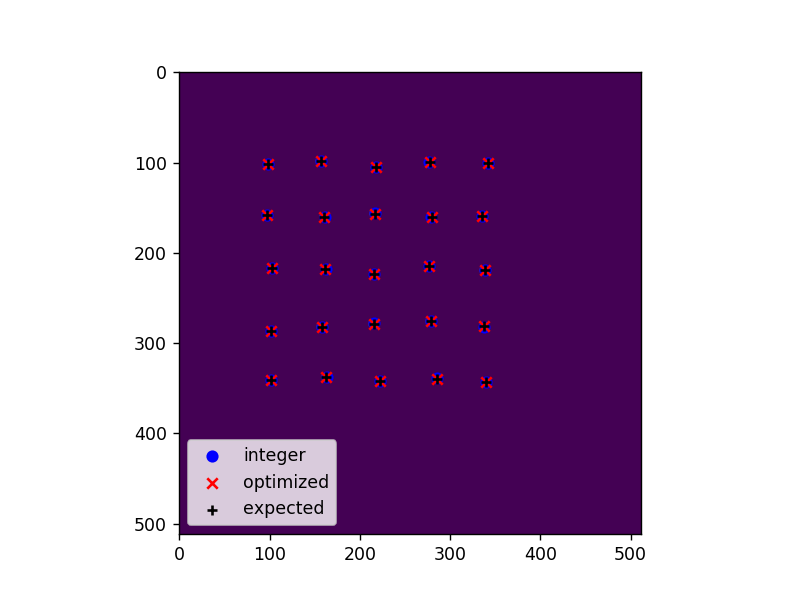

In [7]:
fg, ax = plt.subplots(1,1)
ax.imshow(simIm)
ax.scatter(coords_found[:,1], coords_found[:,0],c='b',marker='o')
ax.scatter(optPeaks[:,1], optPeaks[:,0],c='r',marker='x')
ax.scatter(coords[:,1], coords[:,0],c='k',marker='+')
_ = ax.legend(['integer', 'optimized', 'expected'])

# Find the error in the fitting
 - Gausssian fitting can be heavily influenced by the tails
 - Some error is expected.

<IPython.core.display.Javascript object>


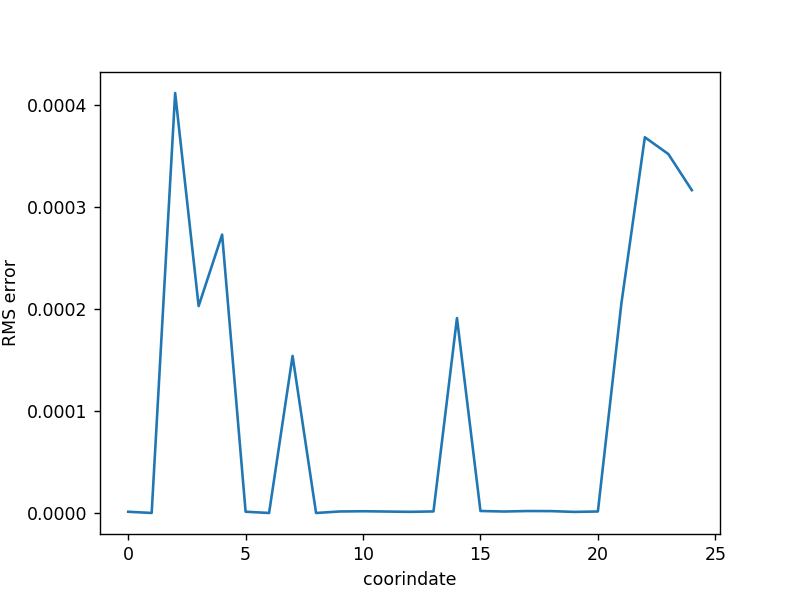

In [8]:
# Plot the RMS error for each fitted peak
# First sort each set of coordinates to match them
err = []
for a, b in zip(coords[np.argsort(coords[:,0]),:], optPeaks[np.argsort(optPeaks[:,0]),0:2]):
    err.append(np.sqrt(np.sum(a - b)**2))
    
fg, ax = plt.subplots(1, 1)
ax.plot(err)
_ = ax.set(xlabel='coorindate', ylabel='RMS error')

# How does peakFind2D work with the Roll?
 - A very confusing point is the indexing used in meshgrid
 - If you use indexing='ij' then the peak position needs to be plotted in matplotlib backwards (row,col)
 - If you change the meshgrid indexing='xy' then this issue is less confusing BUT....
 - Default indexing used to be 'ij' when I wrote this (and lots of other) code. So, now I stick with that convention.

In [9]:
# Copy doubleRoll from ncempy.algo.peakFind
# to look at the algorithm
def doubleRoll(image,vec):
    return np.roll(np.roll(image, vec[0], axis=0), vec[1], axis=1)

# Create a single 2D Gaussian peak

<IPython.core.display.Javascript object>


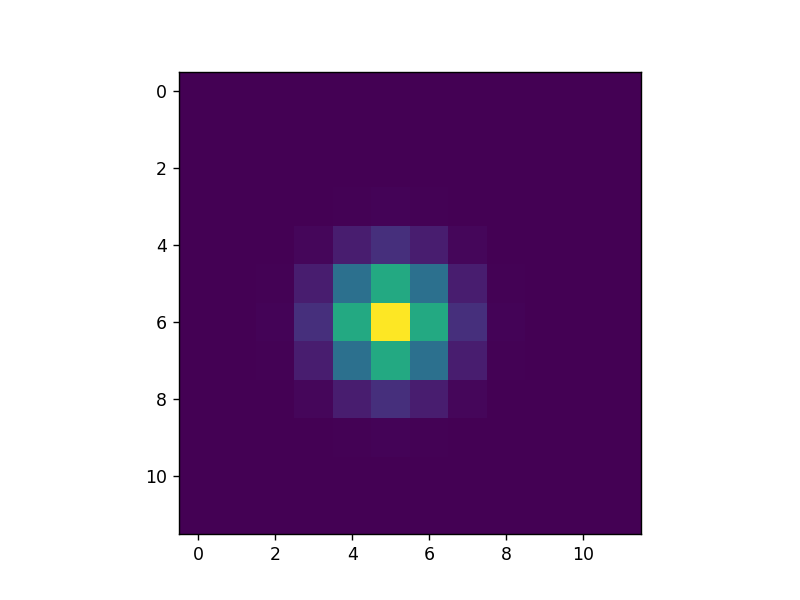

In [10]:
known_peak = [6, 5]

YY, XX = np.meshgrid(range(0,12),range(0,12),indexing='ij')
gg = gaussND.gauss2D(XX,YY,known_peak[1], known_peak[0],1,1)
gg = np.round(gg,decimals=3)

plt.figure()
plt.imshow(gg)

# Roll the array 1 pixel in each direction
 - Compare the original and the rolled version
 - The peak will be moved by 1 pixel in each direction in each case
 - Here I ignore the next nearest neighbors (-1,-1) for simplicity. (peakFind.doubleRoll2D does not ignore these).
 - The peak will always be larger than the element-by-element comparison in each roll

<IPython.core.display.Javascript object>


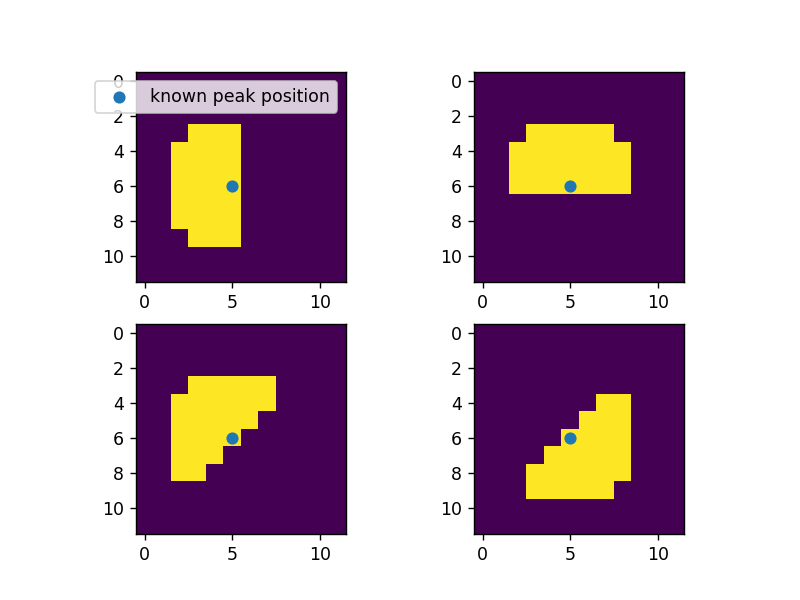

In [11]:
# Compare only nearest neighbors
roll01 = gg > doubleRoll(gg, [0, 1])
roll10 = gg > doubleRoll(gg, [1, 0])
roll11 = gg > doubleRoll(gg, [1, 1])
roll_1_1 = gg > doubleRoll(gg, [-1, -1])

fg,ax = plt.subplots(2,2)
ax[0,0].imshow(roll01)
ax[0,1].imshow(roll10)
ax[1,0].imshow(roll11)
ax[1,1].imshow(roll_1_1)

for aa in ax.ravel():
    aa.scatter(known_peak[1], known_peak[0])

ax[0,0].legend(['known peak position'])

# Compare each rolled image
 - use logical and to find the pixel which was highest in every comparison
 - The local peak will be the only one left

<IPython.core.display.Javascript object>


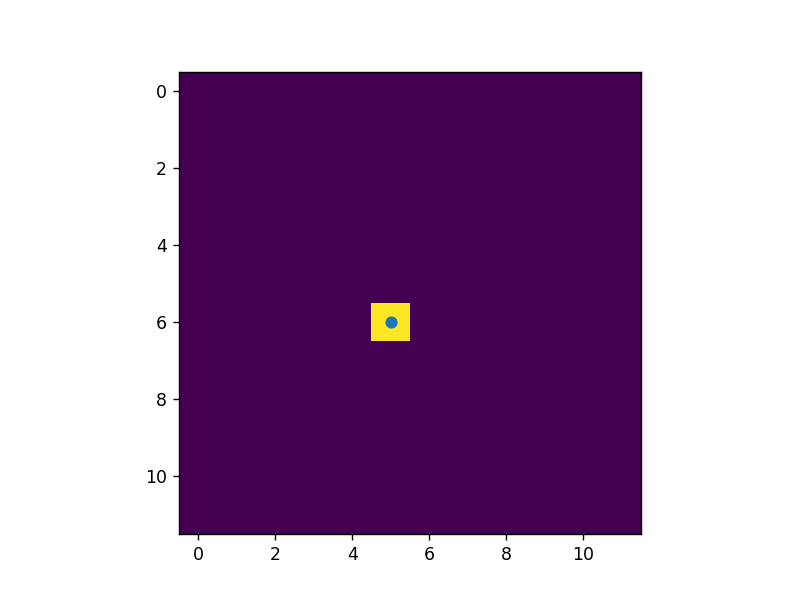

In [12]:
final = roll01 & roll10 & roll11 & roll_1_1

fg,ax = plt.subplots(1,1)
ax.imshow(final)
ax.scatter(known_peak[1],known_peak[0])


# Find the peak using where
 - We have a bool array above.
 - np.where will return the elements of the True values which correspond to the peak position(s)

In [13]:
peak_position = np.array(np.where(final))
print(peak_position)

[[6]
 [5]]
